## China & Japan Forecast

In [50]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [51]:
# Define key functions

# De-difference forecasted results
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    cols = df_train.columns
    for col in cols:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

# Log transformation
def log_trans(df):
    negative_cols = df.columns[df.min() < 0]

    df_transformed = df.copy()
    for col in negative_cols:
        constant = abs(df[col].min()) + 1
        df_transformed[col] = np.log(df[col] + constant)

    for col in df.columns.difference(negative_cols):
        df_transformed[col] = np.log(df[col])

    return df_transformed

In [52]:
def generate_forecast(df, iron_ore_up, hcc_up, scrap_up, export_perc_up, fai_up, iron_ore_down, hcc_down, scrap_down, export_perc_down, fai_down, months_ahead):
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    '''VAR MODEL'''
    # After feature selection, these are the shortlisted variables
    list_of_variables = ['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
        'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
        'Monthly Export of Semis & Finished Steel as % of Production',
        'FAI in urban real estate development (y-o-y) Growth',
        'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
        'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']
    hrc = ['HRC (FOB, $/t)']
    final_cols = hrc + list_of_variables
    final_df = df.copy()
    final_df = final_df[final_cols]

    # Difference data to achieve stationarity
    final_df_differenced = final_df.diff().dropna()

    # Determine the best number of lags
    var_model = VAR(final_df_differenced)
    x = var_model.select_order(maxlags=12)

    # Fit model with optimal lag
    model_fitted = var_model.fit(4)

    # Using the last _ observations (since lag order is _) to forecast the following periods
    lag_order = model_fitted.k_ar
    forecast_input = final_df_differenced.values[-lag_order:]

    # Forecast the following periods
    fc = model_fitted.forecast(y=forecast_input, steps=months_ahead)
    fc_period = pd.date_range(start='11/1/2024', periods=months_ahead, freq='MS')
    df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df.columns + '_1d')
    df_forecast.index.name = 'Date'

    # De-difference forecasted results
    df_forecast_processed = invert_transformation(final_df, df_forecast)


    '''MULTIPLE LINEAR REGRESSION MODEL'''
    # Define x and y variables
    X = df[list_of_variables]
    y = df['HRC (FOB, $/t)']

    # Split into train and test sets
    X_transformed = log_trans(X)

    # Model fitting
    lr_model = LinearRegression()
    lr_model.fit(X_transformed, y)

    # Reading var predictions for X variables
    forecasted_X = df_forecast_processed[['Iron Ore (CFR, $/t)_forecast', 'HCC (Aus FOB, $/t)_forecast',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast',
         'FAI in urban real estate development (y-o-y) Growth_forecast',
         'Automobile Production (y-o-y)_forecast', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast',
         'Household Fridges (y-o-y)_forecast', 'Air Conditioner (y-o-y)_forecast']].copy()
    
    # Scale var predictions
    forecasted_X.rename(columns={'Iron Ore (CFR, $/t)_forecast':'Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)_forecast':'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast':'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production_forecast':'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth_forecast':'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)_forecast':'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)_forecast':'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)_forecast':'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)_forecast':'Air Conditioner (y-o-y)'}, inplace=True)
    forecasted_X_transformed = log_trans(forecasted_X)

    # Obtain y forecast
    y_forecast = lr_model.predict(forecasted_X_transformed)
    y_forecast_new = np.insert(y_forecast, 0, df['HRC (FOB, $/t)'][-1])

    forecast_period = pd.date_range(start=df.index[-1], periods=months_ahead+1, freq='MS')
    final_forecast = pd.DataFrame(y_forecast_new, index=forecast_period, columns=['HRC (FOB, $/t)_f'])
    final_forecast.index.name = 'Date'

    # Def code for forecasting China's upside and downside
    def forecast_china_upside_downside(iron_ore, hcc, scrap, export_perc, fai, var_forecast):
          fc_p = pd.date_range(start=var_forecast.index[0], end=var_forecast.index[-1], freq='MS')
          up_down_df = pd.DataFrame(np.nan, index=fc_p, columns=['Iron Ore (CFR, $/t)',
                                                                 'HCC (Aus FOB, $/t)',
                                                                 'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
                                                                 'Monthly Export of Semis & Finished Steel as % of Production',
                                                                 'FAI in urban real estate development (y-o-y) Growth',
                                                                 'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
                                                                 'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)'])
          up_down_df.index.name = 'Date'
          up_down_df['Iron Ore (CFR, $/t)'] = iron_ore
          up_down_df['HCC (Aus FOB, $/t)'] = hcc
          up_down_df['Domestic Scrap (DDP Jiangsu incl. VAT $/t)'] = scrap
          up_down_df['Monthly Export of Semis & Finished Steel as % of Production'] = export_perc
          up_down_df['FAI in urban real estate development (y-o-y) Growth'] = fai
          up_down_df['Automobile Production (y-o-y)'] = var_forecast['Automobile Production (y-o-y)_forecast']
          up_down_df['Civil Metal-Vessels/Steel Ships (y-o-y)'] = var_forecast['Civil Metal-Vessels/Steel Ships (y-o-y)_forecast']
          up_down_df['Household Fridges (y-o-y)'] = var_forecast['Household Fridges (y-o-y)_forecast']
          up_down_df['Air Conditioner (y-o-y)'] = var_forecast['Air Conditioner (y-o-y)_forecast']

          up_down_transformed = log_trans(up_down_df)

          up_down_f = lr_model.predict(up_down_transformed)
          up_down_f_new = np.insert(up_down_f, 0, df['HRC (FOB, $/t)'][-1])

          fc_dates = pd.date_range(start=df.index[-1], periods=months_ahead+1, freq='MS')
          up_down_forecast = pd.DataFrame(up_down_f_new, index=fc_dates, columns=['China HRC (FOB, $/t)'])
          up_down_forecast.index.name = 'Date'
          return up_down_forecast
    
    # Forecasting China's upside and downside
    CN_forecast_upside = forecast_china_upside_downside(iron_ore_up, hcc_up, scrap_up, export_perc_up, fai_up, df_forecast_processed)
    CN_forecast_downside = forecast_china_upside_downside(iron_ore_down, hcc_down, scrap_down, export_perc_down, fai_down, df_forecast_processed)
    

    '''JAPAN FORECAST'''
    hrc_price_CN_JP = pd.read_csv('../data/final/hrc_price_CN_JP.csv')
    hrc_price_CN_JP.dropna(inplace=True)
    hrc_price_CN_JP.set_index('Date', inplace=True)
    hrc_price_CN_JP.index = pd.to_datetime(hrc_price_CN_JP.index)
    hrc_price_CN_JP = hrc_price_CN_JP[:-1]

    # Prepare X and y columns
    X_JP = hrc_price_CN_JP[["China HRC (FOB, $/t)"]]
    y_JP = hrc_price_CN_JP["Japan HRC (FOB, $/t)"]

    # Split data into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_JP, y_JP, test_size=0.2, random_state=42)

    # Working with second degree polynomial
    poly = PolynomialFeatures(degree=2, include_bias=False)

    # Transform training data for model testing
    X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training

    # Train the model using transformed training data
    model_poly = LinearRegression()
    model_poly_fitted = model_poly.fit(X_train_poly, y_train)

    # Use the trained model for prediction
    # 1. Obtain x (China's HRC price with polynomial features)
    x_CN = final_forecast[['HRC (FOB, $/t)_f']].loc[final_forecast.index > '2025-01-01'].copy()
    x_CN.rename(columns={'HRC (FOB, $/t)_f':'China HRC (FOB, $/t)'}, inplace=True)
    x_CN_poly_trans = poly.transform(x_CN) # transform China's HRC price to achieve polinomial features with degree=2
    
    # 2. Obtain y forecast (Japan's HRC price)
    y_JP_forecast = model_poly_fitted.predict(x_CN_poly_trans)
    y_JP_forecast_new = np.insert(y_JP_forecast, 0, hrc_price_CN_JP['Japan HRC (FOB, $/t)'].loc['2025-01-01'])
    fc_period_JP = pd.date_range(start='2025-01-01', end='2026-03-01', freq='MS')
    df_forecast_JP = pd.DataFrame(y_JP_forecast_new, index=fc_period_JP, columns=['Japan HRC (FOB, $/t)_f'])
    df_forecast_JP.index.name = 'Date'

    # Def code for forecasting Japan's upside and downside
    def forecast_japan_upside_downside(CN_upside_downside):
          # obtain China's upside/downside forecast and filter for Japan's forecast period
          china_forecast = CN_upside_downside[['China HRC (FOB, $/t)']].loc[CN_upside_downside.index > '2025-01-01'].copy()

          # polynomial transformation on China's upside/downside forecast
          china_forecast_poly_trans = poly.transform(china_forecast)

          # obtain Japan's upside/downside forecast
          japan_forecast = model_poly_fitted.predict(china_forecast_poly_trans)
          japan_forecast_new = np.insert(japan_forecast, 0, hrc_price_CN_JP['Japan HRC (FOB, $/t)'].loc['2025-01-01'])
          fc_dates_JP = pd.date_range(start='2025-01-01', end='2026-03-01', freq='MS')
          JP_up_down_forecast = pd.DataFrame(japan_forecast_new, index=fc_dates_JP, columns=['Japan HRC (FOB, $/t)'])
          JP_up_down_forecast.index.name = 'Date'

          return JP_up_down_forecast

    # Forecasting Japan's upside and downside
    JP_forecast_downside = forecast_japan_upside_downside(CN_forecast_downside)
    JP_forecast_upside = forecast_japan_upside_downside(CN_forecast_upside)


    '''CHINA & JAPAN FORECAST'''
    # Plot forecast
    fig, ax = plt.subplots(figsize=(12, 6))
    df["HRC (FOB, $/t)"].plot(color='k', label="China's historical HRC")
    final_forecast['HRC (FOB, $/t)_f'].plot(color='r', linestyle ='dashed', label="China's forecasted HRC")
    ax.fill_between(x=forecast_period, y1=CN_forecast_downside['China HRC (FOB, $/t)'], y2=CN_forecast_upside['China HRC (FOB, $/t)'], color='lightcoral', alpha=0.2, label="China's Upside Downside")
    
    hrc_price_CN_JP["Japan HRC (FOB, $/t)"].plot(color='slategray', label="Japan's historical HRC")
    df_forecast_JP['Japan HRC (FOB, $/t)_f'].plot(color='teal', linestyle ='dashed', label="Japan's forecasted HRC")
    ax.fill_between(x=fc_period_JP, y1=JP_forecast_downside['Japan HRC (FOB, $/t)'], y2=JP_forecast_upside['Japan HRC (FOB, $/t)'], color='palegreen', alpha=0.2, label="Japan's Upside Downside")

    plt.title("Forecasting of China's HRC prices using the Regression model")
    plt.ylabel("HRC (FOB, $/t)")
    plt.xlabel("Date")
    plt.axvline(x = df.index[-1], color = 'red', linestyle = 'dotted')
    plt.axvline(x = '2025-01-01', color = 'teal', linestyle = 'dotted')
    ax.legend(fontsize='small')
    ax.set_xlim(left=pd.Timestamp('2006-09-01'))

In [53]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

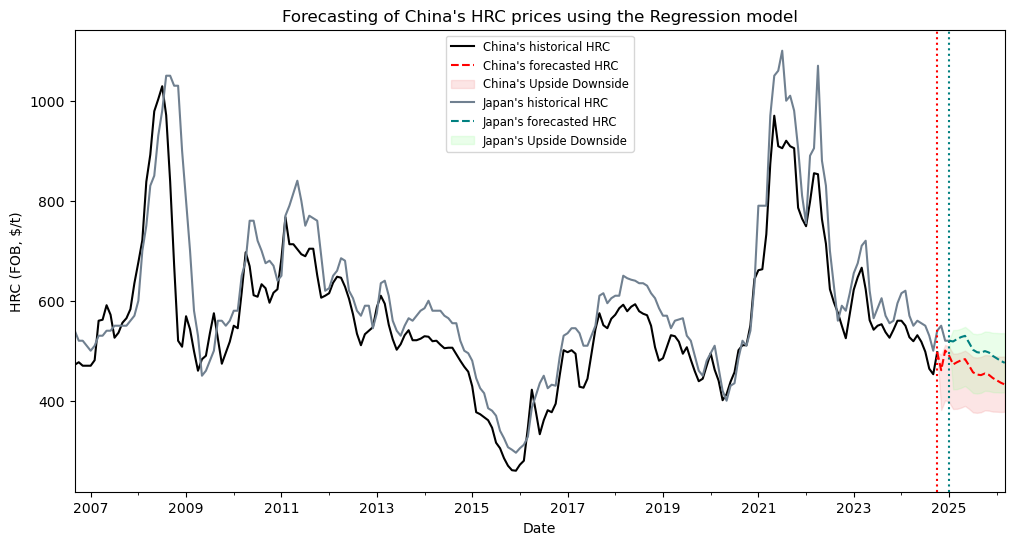

In [54]:
generate_forecast(df, 100, 220, 400, 9, 5, 85, 180, 350, 12, 1, 17)